### PTCDA came in a non-square image. We should preprocess it nicely instead of using that ugly image.

In [1]:
def morgan_fp_gen(smiles, nBits=2048):
    m1 = AllChem.MolFromSmiles(smiles)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(m1,2,nBits=nBits)
    return np.array(fp1)

def load_jmol(path, dimension=[224,224], zoom=1):
    jmol_image = Image.open(path)

    # Determine the aspect ratio by finding the shorter dimension
    width, height = jmol_image.size
    min_dim = min(width, height)

    # Calculate the left, top, right, bottom coordinates for cropping
    left = (width - min_dim) / 2
    top = (height - min_dim) / 2
    right = (width + min_dim) / 2
    bottom = (height + min_dim) / 2

    # Crop the image to square
    jmol_image = jmol_image.crop((left, top, right, bottom))

    # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)

    # Apply zoom by cropping
    width, height = jmol_image.size
    left = width * ((1 - zoom) / 2)
    top = height * ((1 - zoom) / 2)
    right = width * ((1 + zoom) / 2)
    bottom = height * ((1 + zoom) / 2)
    jmol_image = jmol_image.crop((left, top, right, bottom))

    # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)

    # Convert to numpy array
    jmol_image_array = np.array(jmol_image)

    return jmol_image_array

def load_exp_img_stack(path, dimensions=[224,224], zoom=1, normalize=True, interpolation='bilinear'):
    '''Obtains stack of experimental images from folder path and preprocess 
        it so we can directly feed it to our CNN

        INPUT: path of the folder containing the AFM images of the molecule

        OUTPUT: list of PIL images'''
    path_list = sorted(glob.glob(os.path.join(path,'*')))
    im_list = list()
    for im_path in path_list:
        
        im_list.append(Image.open(im_path).resize(dimensions, resample=Image.Resampling.BILINEAR).convert('L'))
        
    # Default parameters
        degrees = 0
        h_shift = 0
        v_shift = 0
        shear = 0

        
    for i in range(len(im_list)):
        im_list[i] = TF.affine(im_list[i], degrees, [h_shift, v_shift], zoom, shear,
                                interpolation=transforms.InterpolationMode.BILINEAR,
                                fill=im_list[i].getpixel((5, 5))
                                )

    to_tensor = transforms.ToTensor()

    tensor_stack = [to_tensor(im) for im in im_list.copy()]
    tensor_stack = torch.cat(tensor_stack)

    #normalize = transforms.Normalize(
    #    mean=[0.1321, 0.1487, 0.1689, 0.1983, 0.2229, 0.2591, 0.3430, 0.4580, 0.5787, 0.6887],
    #    std=[0.0853, 0.0853, 0.0883, 0.0942, 0.0969, 0.1066, 0.1419, 0.1840, 0.2144, 0.2215]) #this is for K-1

    
    if normalize:

        normalize = transforms.Normalize(
            mean=[0.2855, 0.3973, 0.4424, 0.4134, 0.6759, 1.0664, 0.9904, 0.7708, 0.5748, 0.4055],
            std=[1.1341, 1.2528, 1.3125, 1.3561, 1.5844, 1.7763, 1.5447, 1.2683, 1.0588, 0.9308]) # for all K folders

        tensor_stack = normalize(tensor_stack)

    return tensor_stack

def load_exp_3_img(path, dimensions=[224,224], zoom=1):
    '''Obtains stack of experimental images from folder path and preprocess 
        it so we can directly feed it to our CNN

        INPUT: path of the folder containing the AFM images of the molecule

        OUTPUT: list of PIL images'''
    path_list = sorted(glob.glob(os.path.join(path,'*')))
    im_list = list()
    for im_index in [1,4,7]:
        
        im_list.append(Image.open(path_list[im_index]).resize(dimensions, resample=Image.Resampling.BILINEAR).convert('L'))
        
    # Default parameters
        degrees = 0
        h_shift = 0
        v_shift = 0
        shear = 0

        
    for i in range(len(im_list)):
        im_list[i] = TF.affine(im_list[i], degrees, [h_shift, v_shift], zoom, shear,
                                interpolation=transforms.InterpolationMode.BILINEAR,
                                fill=im_list[i].getpixel((5, 5))
                                )

    to_tensor = transforms.ToTensor()

    tensor_stack = [to_tensor(im) for im in im_list.copy()]
    tensor_stack = torch.cat(tensor_stack)

    normalize = transforms.Normalize(
        mean=[0.1487, 0.2229, 0.4580],
        std=[0.0853, 0.0969, 0.1840])
        

    tensor_stack = normalize(tensor_stack)

    return tensor_stack

def load_jmol_image(cid, dimension=[224,224], zoom=1):
    if USER=='manuel':
        path = f'/home/{USER}/QUAM-AFM/QUAM/JMOL_IMAGES/{cid}/{cid}.png' ##Mustang
    else:
        path = f'/scratch/dataset/quam/JMOL_IMAGES/{cid}/{cid}.png' ##Rocinante
    jmol_image = Image.open(path)
     # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)
    
    
    # Apply zoom by cropping
    width, height = jmol_image.size
    left = width * ((1 - zoom) / 2)
    top = height * ((1 - zoom) / 2)
    right = width * ((1 + zoom) / 2)
    bottom = height * ((1 + zoom) / 2)
    jmol_image = jmol_image.crop((left, top, right, bottom))
    
    # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)
    
    # Convert to numpy array
    jmol_image_array = np.array(jmol_image)
    
    return jmol_image_array

def _extract_cid(path):
    return int(path.split('_')[-3])

In [2]:
def load_exp_img_stack(path, dimensions=[224,224], zoom=1, normalize=True, interpolation='bilinear'):
    '''
    Obtains stack of experimental images from folder path and preprocesses 
    it so we can directly feed it to our CNN.

    Inputs:
    - path: Path of the folder containing the AFM images of the molecule.
    - dimensions: Desired dimensions for the output images. Default is [224,224].
    - zoom: Zoom level for the images. zoom <1 is zoom out and >1 zoom in. Default is 1.
    - normalize: If True, normalizes the output. Default is True.
    - interpolation: Interpolation method to be used. Options are 'bilinear', 'nearest', and 'bicubic'. 
                     Default is 'bilinear'.

    Output:
    - list of PIL images.
    '''
    interpolation_methods = {
        'bilinear': Image.Resampling.BILINEAR,
        'nearest': Image.Resampling.NEAREST,
        'bicubic': Image.Resampling.BICUBIC
    }

    torch_interpolation_methods = {
        'bilinear': transforms.InterpolationMode.BILINEAR,
        'nearest': transforms.InterpolationMode.NEAREST,
        'bicubic': transforms.InterpolationMode.BICUBIC
    }

    if interpolation not in interpolation_methods:
        raise ValueError(f'Interpolation method not recognized. Please use one of {list(interpolation_methods.keys())}.')

    path_list = sorted(glob.glob(os.path.join(path,'*')))
    im_list = list()
    for im_path in path_list:        
        im_list.append(Image.open(im_path).resize(dimensions, resample=interpolation_methods[interpolation]).convert('L'))
        
    # Default parameters
    degrees = 0
    h_shift = 0
    v_shift = 0
    shear = 0

    for i in range(len(im_list)):
        im_list[i] = TF.affine(im_list[i], degrees, [h_shift, v_shift], zoom, shear,
                                interpolation=torch_interpolation_methods[interpolation],
                                fill=im_list[i].getpixel((5, 5))
                                )

    to_tensor = transforms.ToTensor()

    tensor_stack = [to_tensor(im) for im in im_list.copy()]
    tensor_stack = torch.cat(tensor_stack)

    if normalize:
        normalize = transforms.Normalize(
            mean=[0.2855, 0.3973, 0.4424, 0.4134, 0.6759, 1.0664, 0.9904, 0.7708, 0.5748, 0.4055],
            std=[1.1341, 1.2528, 1.3125, 1.3561, 1.5844, 1.7763, 1.5447, 1.2683, 1.0588, 0.9308]) # for all K folders

        tensor_stack = normalize(tensor_stack)

    return tensor_stack



In [43]:
# IMPORTS
# additional packages
from PIL import Image, ImageOps

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import argparse
import os
import time
import glob
from tqdm import tqdm
import scipy
import seaborn as sns
import rdkit.Chem.AllChem as AllChem
import sys
USER = os.getenv('USER')
sys.path.append(f'/home/{USER}/CODE/Pytorch-fingerprints/')
# torch packages
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch import optim
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_b0, EfficientNet_B0_Weights
import torchvision.transforms.functional as TF

from torchmetrics import MetricCollection
from torchmetrics.classification import MultilabelRecall, MultilabelPrecision, MultilabelF1Score

import torch.nn.functional as F
from torch.utils.data import Dataset

print('PyTorch version:', torch.__version__)

# custom functions
from utils.all_utils import train_test_split, compute_pos_weights, save_config, train_for_epoch, validate, \
                            balance_beta_pos_weights, tanimoto_torch, validate_tanimoto

from utils.models import ResNet3D, resnet_10_chan, effnet_10_chan, eff_net_bias_warmer, resnet_bias_warmer 

from utils.dataloader import QUAM

from utils.screening import fp_screening_function, load_img_stack, predict_fp, tanimoto_numpy





print('Packages loaded')


class configuration:
    def __init__(self):
        # EXPERIMENT PARAMETERS
        self.experiment_name = 'exp_imgs'
        self.n_fp = 1024  # number of fingerprints
        self.output_size = 10
        self.ratio = 0.95  # train/test ratio
        self.seed = 42

        # TRAINING PARAMETERS

        self.lr = 0.001  # learning rate
        self.dropout = 0.5 # Dropout2d probability
        # self.momentum = 0.9  # momentum of SGD optimizer
        self.weight_decay = 0  # L2 regularization constant
        self.batch_size = 50  # Training batch size
        self.test_batch_size = 50  # Test batch size
        self.epochs = 150  # Number of epochs
        self.bias_warmer = True # setting appropiate bias
        self.pos_weight_balancer = True #for bigger fingerprints, it helps balance precision and recall
        self.pos_weight_beta = 10
        # DATA AUGMENTATION PARAMETERS

        # Rotation
        self.rot_prob = 0.5  # prob of rotation in data augmentation
        self.max_deg = 180  # maximum degrees of rotation in data augmentation

        # Zoom
        self.zoom_prob = 0.3  # prob of applying zoom
        self.max_zoom = 0.3  # maximum zooming in/out

        # Translation
        self.shift_prob = 0.3  # probability of vertical or/and horizontal translation
        self.max_shift = 20  # translation

        # Shear
        self.shear_prob = 0.3  # probability of shearing
        self.max_shear = 10  # maximum shearing angle

## Create arguments object
args = configuration()
# Print experiment name
print('Experiment name:', args.experiment_name)


# make sure to enable GPU acceleration!
print(f'available devices: {torch.cuda.device_count()}')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#torch.cuda.device(0)
#device = torch.device('cpu')
#print(device, torch.cuda.get_device_name(0))

# Set random seed for reproducibility
torch.backends.cudnn.deterministic = True  # fix the GPU to deterministic mode
torch.manual_seed(args.seed)  # CPU seed
torch.cuda.manual_seed_all(args.seed)  # GPU seed
random.seed(args.seed)  # python seed for image transformation
np.random.seed(args.seed)



PyTorch version: 1.12.1
Packages loaded
Experiment name: exp_imgs
available devices: 0


In [28]:
path = f'/home/{USER}/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA' 


path_list = sorted(glob.glob(os.path.join(path,'*')))
print(path_list)
im_list = list()
for im_path in path_list:        
    im_list.append(Image.open(im_path).convert('L'))

['/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_0.jpg', '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_1.jpg', '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_2.jpg', '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_3.jpg', '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_4.jpg', '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_5.jpg', '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_6.jpg', '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_7.jpg', '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_8.jpg', '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_9.jpg']


In [29]:
path_1_img = '/home/mgonzalez/EXPERIMENTAL_IMAGES/RAW/Perylenetetracarboxylic_dianhydride_PTCDA/image_0.jpg'

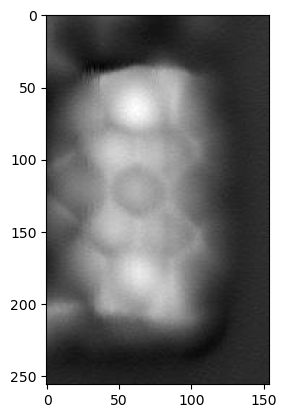

In [16]:
plt.imshow(im_list[0], cmap='gray')

In [17]:
def load_and_process_image(img, desired_size):
    """
    Loads a non-square image, performs a zoom out, and then crops it to make it square.

    :param img: PIL image.
    :param desired_size: The size (width and height) of the resulting square image.
    :return: Cropped square image.
    """
    # Load the image
    

    # Calculate the scale to fit the image into the desired size
    scale = min(desired_size / img.width, desired_size / img.height)

    # Resize (zoom out) the image
    new_size = (int(img.width * scale), int(img.height * scale))
    img = img.resize(new_size, Image.ANTIALIAS)

    # Calculate cropping area
    left = (img.width - desired_size) / 2
    top = (img.height - desired_size) / 2
    right = (img.width + desired_size) / 2
    bottom = (img.height + desired_size) / 2

    # Crop the image to a square
    img = img.crop((left, top, right, bottom))

    return img

/tmp/ipykernel_128252/3360472168.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(new_size, Image.ANTIALIAS)


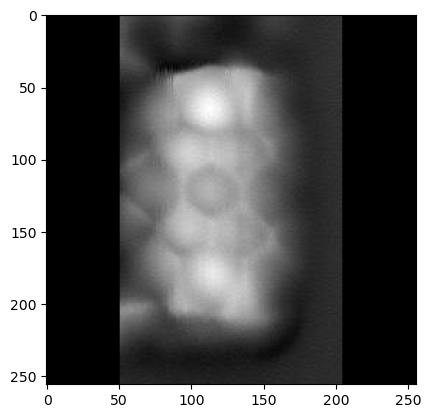

In [19]:
resized_image = load_and_process_image(im_list[0], 256)
plt.imshow(resized_image, cmap='gray')

In [24]:
def zoom_out_image(img, max_width, max_height, save_path=None):
    """
    Zooms out an image to fit within the specified dimensions while maintaining aspect ratio.

    :param img: Path to the input image.
    :param max_width: Maximum width of the zoomed-out image.
    :param max_height: Maximum height of the zoomed-out image.
    :param save_path: Optional path to save the zoomed-out image.
    :return: Zoomed-out image object.
    """
    # Load the image

    # Calculate the scaling factor to maintain aspect ratio
    scale = min(max_width / img.width, max_height / img.height)

    # Calculate new size
    new_size = (int(img.width * scale), int(img.height * scale))

    # Resize (zoom out) the image
    img = img.resize(new_size)

    # Save or return the image
    if save_path:
        img.save(save_path)
    return img

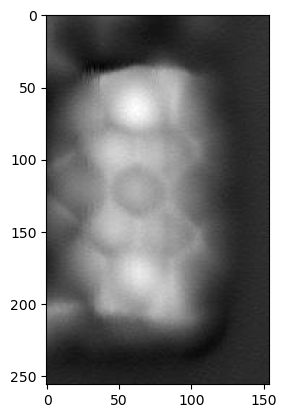

In [27]:

resized_image = zoom_out_image(im_list[0], 256,256, save_path=None)
plt.imshow(resized_image, cmap='gray')

/tmp/ipykernel_128252/560638037.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)


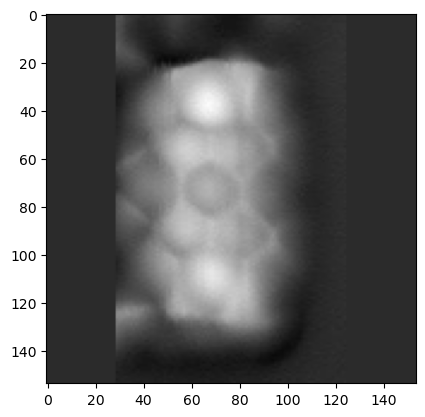

In [50]:
def zoom_out_and_crop(image_path, zoom):
    # Open the image
    with Image.open(image_path) as img:
        # Calculate the new size, zooming out
        new_width = int(img.width / zoom)
        new_height = int(img.height / zoom)

        # Resize the image
        resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)

        # Calculate padding to add to each side
        delta_w = img.width - new_width
        delta_h = img.height - new_height
        padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
        
        fill = img.getpixel((-5, -5))

        # Pad the resized image to get back to original size
        padded_img = ImageOps.expand(resized_img, padding, fill = fill)

        # Crop the image to make it square
        min_dimension = min(padded_img.width, padded_img.height)
        left = (padded_img.width - min_dimension) // 2
        top = (padded_img.height - min_dimension) // 2
        right = (padded_img.width + min_dimension) // 2
        bottom = (padded_img.height + min_dimension) // 2

        cropped_img = padded_img.crop((left, top, right, bottom))

        return cropped_img

resized_img = zoom_out_and_crop(path_1_img, zoom=1.6)    
plt.imshow(resized_img, cmap='gray')

In [51]:
folder_path = '/home/mgonzalez/EXPERIMENTAL_IMAGES/PADDED/Perylenetetracarboxylic_dianhydride_PTCDA'

for i, path in enumerate(path_list):
    resized_img = zoom_out_and_crop(path, zoom=1.6)  
    img_path = os.path.join(folder_path, f'image_{i}.jpg')
    resized_img.save(img_path)

/tmp/ipykernel_128252/560638037.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
